# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/frame

## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

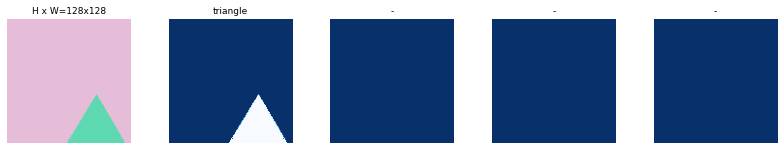

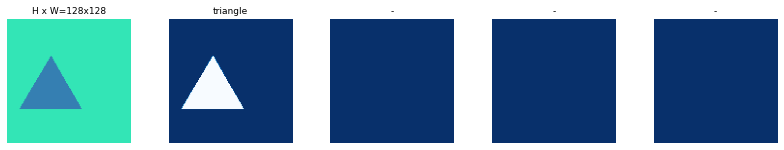

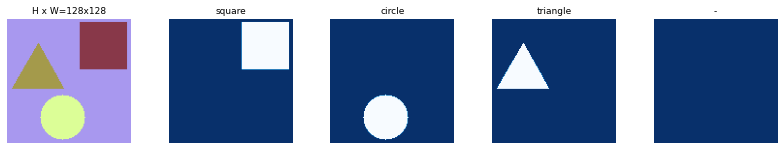

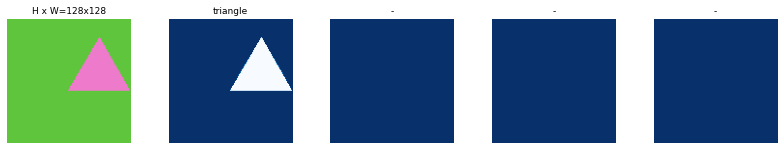

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ec2-user/SageMaker/Mask_RCNN/logs/shapes20220306T1914/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribute

/home/ec2-user/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ec2-user/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order

Epoch 1/1


/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  1/100 [..............................] - ETA: 24:09 - loss: 5.9334 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 2.1081 - mrcnn_class_loss: 1.4067 - mrcnn_bbox_loss: 1.2618 - mrcnn_mask_loss: 1.0791

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  2/100 [..............................] - ETA: 12:07 - loss: 5.5730 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 2.0003 - mrcnn_class_loss: 1.2474 - mrcnn_bbox_loss: 1.2453 - mrcnn_mask_loss: 0.9889

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  3/100 [..............................] - ETA: 8:06 - loss: 5.5206 - rpn_class_loss: 0.0931 - rpn_bbox_loss: 2.0895 - mrcnn_class_loss: 1.1176 - mrcnn_bbox_loss: 1.2221 - mrcnn_mask_loss: 0.9982 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  4/100 [>.............................] - ETA: 6:06 - loss: 5.4982 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 2.1393 - mrcnn_class_loss: 1.0671 - mrcnn_bbox_loss: 1.2261 - mrcnn_mask_loss: 0.9741

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  5/100 [>.............................] - ETA: 4:53 - loss: 5.2992 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 1.9916 - mrcnn_class_loss: 1.0596 - mrcnn_bbox_loss: 1.1897 - mrcnn_mask_loss: 0.9655

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  6/100 [>.............................] - ETA: 4:04 - loss: 5.0465 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 1.8456 - mrcnn_class_loss: 1.0235 - mrcnn_bbox_loss: 1.1359 - mrcnn_mask_loss: 0.9494

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  7/100 [=>............................] - ETA: 3:29 - loss: 4.8847 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 1.7869 - mrcnn_class_loss: 0.9872 - mrcnn_bbox_loss: 1.1004 - mrcnn_mask_loss: 0.9214

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  8/100 [=>............................] - ETA: 3:04 - loss: 4.7013 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 1.6938 - mrcnn_class_loss: 0.9438 - mrcnn_bbox_loss: 1.0768 - mrcnn_mask_loss: 0.8991

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  9/100 [=>............................] - ETA: 2:43 - loss: 4.5283 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 1.6093 - mrcnn_class_loss: 0.9049 - mrcnn_bbox_loss: 1.0493 - mrcnn_mask_loss: 0.8755

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 10/100 [==>...........................] - ETA: 2:27 - loss: 4.4517 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 1.5863 - mrcnn_class_loss: 0.8802 - mrcnn_bbox_loss: 1.0262 - mrcnn_mask_loss: 0.8710

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 11/100 [==>...........................] - ETA: 2:14 - loss: 4.3362 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 1.5237 - mrcnn_class_loss: 0.8629 - mrcnn_bbox_loss: 1.0075 - mrcnn_mask_loss: 0.8547

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 12/100 [==>...........................] - ETA: 2:03 - loss: 4.2182 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 1.4759 - mrcnn_class_loss: 0.8321 - mrcnn_bbox_loss: 0.9865 - mrcnn_mask_loss: 0.8392

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 13/100 [==>...........................] - ETA: 1:53 - loss: 4.0899 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.4150 - mrcnn_class_loss: 0.8063 - mrcnn_bbox_loss: 0.9668 - mrcnn_mask_loss: 0.8191

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 14/100 [===>..........................] - ETA: 1:45 - loss: 3.9611 - rpn_class_loss: 0.0803 - rpn_bbox_loss: 1.3631 - mrcnn_class_loss: 0.7718 - mrcnn_bbox_loss: 0.9448 - mrcnn_mask_loss: 0.8011

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 15/100 [===>..........................] - ETA: 1:38 - loss: 3.8645 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.3186 - mrcnn_class_loss: 0.7501 - mrcnn_bbox_loss: 0.9265 - mrcnn_mask_loss: 0.7900

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 16/100 [===>..........................] - ETA: 1:32 - loss: 3.7710 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.2776 - mrcnn_class_loss: 0.7264 - mrcnn_bbox_loss: 0.9128 - mrcnn_mask_loss: 0.7762

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 17/100 [====>.........................] - ETA: 1:26 - loss: 3.6790 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.2321 - mrcnn_class_loss: 0.7100 - mrcnn_bbox_loss: 0.8951 - mrcnn_mask_loss: 0.7648

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 18/100 [====>.........................] - ETA: 1:21 - loss: 3.6051 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 1.2020 - mrcnn_class_loss: 0.6924 - mrcnn_bbox_loss: 0.8810 - mrcnn_mask_loss: 0.7540

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 19/100 [====>.........................] - ETA: 1:17 - loss: 3.5325 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.1739 - mrcnn_class_loss: 0.6751 - mrcnn_bbox_loss: 0.8657 - mrcnn_mask_loss: 0.7430

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 20/100 [=====>........................] - ETA: 1:13 - loss: 3.4525 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.1475 - mrcnn_class_loss: 0.6565 - mrcnn_bbox_loss: 0.8437 - mrcnn_mask_loss: 0.7312

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 21/100 [=====>........................] - ETA: 1:10 - loss: 3.3827 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.1266 - mrcnn_class_loss: 0.6372 - mrcnn_bbox_loss: 0.8266 - mrcnn_mask_loss: 0.7195

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 22/100 [=====>........................] - ETA: 1:06 - loss: 3.3290 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.1059 - mrcnn_class_loss: 0.6243 - mrcnn_bbox_loss: 0.8133 - mrcnn_mask_loss: 0.7139

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 23/100 [=====>........................] - ETA: 1:03 - loss: 3.2818 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 1.0930 - mrcnn_class_loss: 0.6111 - mrcnn_bbox_loss: 0.7998 - mrcnn_mask_loss: 0.7075

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 24/100 [======>.......................] - ETA: 1:00 - loss: 3.2239 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 1.0745 - mrcnn_class_loss: 0.5991 - mrcnn_bbox_loss: 0.7818 - mrcnn_mask_loss: 0.6989

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 25/100 [======>.......................] - ETA: 58s - loss: 3.1692 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.0505 - mrcnn_class_loss: 0.5876 - mrcnn_bbox_loss: 0.7680 - mrcnn_mask_loss: 0.6945 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 26/100 [======>.......................] - ETA: 55s - loss: 3.1157 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 1.0272 - mrcnn_class_loss: 0.5773 - mrcnn_bbox_loss: 0.7535 - mrcnn_mask_loss: 0.6902

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 27/100 [=======>......................] - ETA: 53s - loss: 3.0616 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 1.0037 - mrcnn_class_loss: 0.5665 - mrcnn_bbox_loss: 0.7403 - mrcnn_mask_loss: 0.6844

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 28/100 [=======>......................] - ETA: 51s - loss: 3.0182 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 0.9871 - mrcnn_class_loss: 0.5594 - mrcnn_bbox_loss: 0.7284 - mrcnn_mask_loss: 0.6779

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 29/100 [=======>......................] - ETA: 49s - loss: 2.9745 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 0.9717 - mrcnn_class_loss: 0.5507 - mrcnn_bbox_loss: 0.7166 - mrcnn_mask_loss: 0.6714

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 30/100 [========>.....................] - ETA: 47s - loss: 2.9309 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.9591 - mrcnn_class_loss: 0.5383 - mrcnn_bbox_loss: 0.7040 - mrcnn_mask_loss: 0.6668

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 31/100 [========>.....................] - ETA: 45s - loss: 2.8880 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.9466 - mrcnn_class_loss: 0.5271 - mrcnn_bbox_loss: 0.6913 - mrcnn_mask_loss: 0.6613

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 32/100 [========>.....................] - ETA: 43s - loss: 2.8562 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.9342 - mrcnn_class_loss: 0.5213 - mrcnn_bbox_loss: 0.6843 - mrcnn_mask_loss: 0.6556

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 33/100 [========>.....................] - ETA: 42s - loss: 2.8217 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 0.9206 - mrcnn_class_loss: 0.5157 - mrcnn_bbox_loss: 0.6751 - mrcnn_mask_loss: 0.6505

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 34/100 [=========>....................] - ETA: 40s - loss: 2.7792 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 0.9054 - mrcnn_class_loss: 0.5065 - mrcnn_bbox_loss: 0.6641 - mrcnn_mask_loss: 0.6445

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 35/100 [=========>....................] - ETA: 39s - loss: 2.7506 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 0.8964 - mrcnn_class_loss: 0.5014 - mrcnn_bbox_loss: 0.6539 - mrcnn_mask_loss: 0.6412

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 36/100 [=========>....................] - ETA: 37s - loss: 2.7177 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 0.8840 - mrcnn_class_loss: 0.4958 - mrcnn_bbox_loss: 0.6457 - mrcnn_mask_loss: 0.6356

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 37/100 [==========>...................] - ETA: 36s - loss: 2.6900 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.8751 - mrcnn_class_loss: 0.4929 - mrcnn_bbox_loss: 0.6359 - mrcnn_mask_loss: 0.6303

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 38/100 [==========>...................] - ETA: 35s - loss: 2.6596 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 0.8637 - mrcnn_class_loss: 0.4884 - mrcnn_bbox_loss: 0.6267 - mrcnn_mask_loss: 0.6259

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 39/100 [==========>...................] - ETA: 33s - loss: 2.6334 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 0.8527 - mrcnn_class_loss: 0.4843 - mrcnn_bbox_loss: 0.6203 - mrcnn_mask_loss: 0.6222

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 40/100 [===========>..................] - ETA: 32s - loss: 2.6041 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 0.8447 - mrcnn_class_loss: 0.4780 - mrcnn_bbox_loss: 0.6115 - mrcnn_mask_loss: 0.6169

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 41/100 [===========>..................] - ETA: 31s - loss: 2.5823 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 0.8365 - mrcnn_class_loss: 0.4765 - mrcnn_bbox_loss: 0.6040 - mrcnn_mask_loss: 0.6130

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 42/100 [===========>..................] - ETA: 30s - loss: 2.5562 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 0.8258 - mrcnn_class_loss: 0.4731 - mrcnn_bbox_loss: 0.5973 - mrcnn_mask_loss: 0.6084

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 43/100 [===========>..................] - ETA: 29s - loss: 2.5308 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 0.8180 - mrcnn_class_loss: 0.4674 - mrcnn_bbox_loss: 0.5905 - mrcnn_mask_loss: 0.6037

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 44/100 [============>.................] - ETA: 28s - loss: 2.5064 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 0.8096 - mrcnn_class_loss: 0.4620 - mrcnn_bbox_loss: 0.5857 - mrcnn_mask_loss: 0.5987

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 45/100 [============>.................] - ETA: 27s - loss: 2.4874 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.8026 - mrcnn_class_loss: 0.4604 - mrcnn_bbox_loss: 0.5796 - mrcnn_mask_loss: 0.5950

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 46/100 [============>.................] - ETA: 26s - loss: 2.4653 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.7944 - mrcnn_class_loss: 0.4580 - mrcnn_bbox_loss: 0.5730 - mrcnn_mask_loss: 0.5907

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 47/100 [=============>................] - ETA: 25s - loss: 2.4405 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.7867 - mrcnn_class_loss: 0.4530 - mrcnn_bbox_loss: 0.5660 - mrcnn_mask_loss: 0.5864

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 48/100 [=============>................] - ETA: 25s - loss: 2.4215 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.7823 - mrcnn_class_loss: 0.4484 - mrcnn_bbox_loss: 0.5604 - mrcnn_mask_loss: 0.5824

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 49/100 [=============>................] - ETA: 24s - loss: 2.4047 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.7763 - mrcnn_class_loss: 0.4458 - mrcnn_bbox_loss: 0.5554 - mrcnn_mask_loss: 0.5796

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 50/100 [==============>...............] - ETA: 23s - loss: 2.3822 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.7698 - mrcnn_class_loss: 0.4418 - mrcnn_bbox_loss: 0.5484 - mrcnn_mask_loss: 0.5752

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 51/100 [==============>...............] - ETA: 22s - loss: 2.3629 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.7635 - mrcnn_class_loss: 0.4375 - mrcnn_bbox_loss: 0.5433 - mrcnn_mask_loss: 0.5722

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 52/100 [==============>...............] - ETA: 21s - loss: 2.3462 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.7568 - mrcnn_class_loss: 0.4346 - mrcnn_bbox_loss: 0.5391 - mrcnn_mask_loss: 0.5697

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 53/100 [==============>...............] - ETA: 21s - loss: 2.3297 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.7507 - mrcnn_class_loss: 0.4327 - mrcnn_bbox_loss: 0.5337 - mrcnn_mask_loss: 0.5672

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 54/100 [===============>..............] - ETA: 20s - loss: 2.3116 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.7442 - mrcnn_class_loss: 0.4295 - mrcnn_bbox_loss: 0.5286 - mrcnn_mask_loss: 0.5644

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 55/100 [===============>..............] - ETA: 19s - loss: 2.2921 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.7363 - mrcnn_class_loss: 0.4272 - mrcnn_bbox_loss: 0.5234 - mrcnn_mask_loss: 0.5609

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 56/100 [===============>..............] - ETA: 19s - loss: 2.2738 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.7314 - mrcnn_class_loss: 0.4239 - mrcnn_bbox_loss: 0.5184 - mrcnn_mask_loss: 0.5564

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 57/100 [================>.............] - ETA: 18s - loss: 2.2554 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.7266 - mrcnn_class_loss: 0.4183 - mrcnn_bbox_loss: 0.5137 - mrcnn_mask_loss: 0.5535

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 58/100 [================>.............] - ETA: 17s - loss: 2.2431 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.7246 - mrcnn_class_loss: 0.4150 - mrcnn_bbox_loss: 0.5099 - mrcnn_mask_loss: 0.5507

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 59/100 [================>.............] - ETA: 17s - loss: 2.2249 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.7189 - mrcnn_class_loss: 0.4112 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.5473

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 60/100 [=================>............] - ETA: 16s - loss: 2.2070 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.7133 - mrcnn_class_loss: 0.4079 - mrcnn_bbox_loss: 0.4999 - mrcnn_mask_loss: 0.5439

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 61/100 [=================>............] - ETA: 16s - loss: 2.1912 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7102 - mrcnn_class_loss: 0.4040 - mrcnn_bbox_loss: 0.4945 - mrcnn_mask_loss: 0.5409

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 62/100 [=================>............] - ETA: 15s - loss: 2.1772 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.7051 - mrcnn_class_loss: 0.4011 - mrcnn_bbox_loss: 0.4908 - mrcnn_mask_loss: 0.5391

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 63/100 [=================>............] - ETA: 15s - loss: 2.1580 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.6997 - mrcnn_class_loss: 0.3965 - mrcnn_bbox_loss: 0.4853 - mrcnn_mask_loss: 0.5358

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 64/100 [==================>...........] - ETA: 14s - loss: 2.1427 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.6953 - mrcnn_class_loss: 0.3938 - mrcnn_bbox_loss: 0.4811 - mrcnn_mask_loss: 0.5322

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 65/100 [==================>...........] - ETA: 13s - loss: 2.1266 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.6903 - mrcnn_class_loss: 0.3897 - mrcnn_bbox_loss: 0.4775 - mrcnn_mask_loss: 0.5292

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 66/100 [==================>...........] - ETA: 13s - loss: 2.1152 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.6867 - mrcnn_class_loss: 0.3877 - mrcnn_bbox_loss: 0.4740 - mrcnn_mask_loss: 0.5270

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 67/100 [===================>..........] - ETA: 12s - loss: 2.1012 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6829 - mrcnn_class_loss: 0.3841 - mrcnn_bbox_loss: 0.4704 - mrcnn_mask_loss: 0.5245

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 68/100 [===================>..........] - ETA: 12s - loss: 2.0883 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.6796 - mrcnn_class_loss: 0.3815 - mrcnn_bbox_loss: 0.4668 - mrcnn_mask_loss: 0.5214

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 69/100 [===================>..........] - ETA: 11s - loss: 2.0759 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.6774 - mrcnn_class_loss: 0.3784 - mrcnn_bbox_loss: 0.4630 - mrcnn_mask_loss: 0.5184

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 70/100 [====================>.........] - ETA: 11s - loss: 2.0601 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.6738 - mrcnn_class_loss: 0.3741 - mrcnn_bbox_loss: 0.4587 - mrcnn_mask_loss: 0.5151

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 71/100 [====================>.........] - ETA: 11s - loss: 2.0491 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.6689 - mrcnn_class_loss: 0.3725 - mrcnn_bbox_loss: 0.4559 - mrcnn_mask_loss: 0.5137

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 72/100 [====================>.........] - ETA: 10s - loss: 2.0362 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.6659 - mrcnn_class_loss: 0.3691 - mrcnn_bbox_loss: 0.4523 - mrcnn_mask_loss: 0.5112

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 73/100 [====================>.........] - ETA: 10s - loss: 2.0237 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.6627 - mrcnn_class_loss: 0.3659 - mrcnn_bbox_loss: 0.4494 - mrcnn_mask_loss: 0.5080

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 74/100 [=====================>........] - ETA: 9s - loss: 2.0111 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6599 - mrcnn_class_loss: 0.3633 - mrcnn_bbox_loss: 0.4457 - mrcnn_mask_loss: 0.5049 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 75/100 [=====================>........] - ETA: 9s - loss: 2.0003 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.6570 - mrcnn_class_loss: 0.3609 - mrcnn_bbox_loss: 0.4426 - mrcnn_mask_loss: 0.5028

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 76/100 [=====================>........] - ETA: 8s - loss: 1.9869 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.6544 - mrcnn_class_loss: 0.3573 - mrcnn_bbox_loss: 0.4392 - mrcnn_mask_loss: 0.4993

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 77/100 [======================>.......] - ETA: 8s - loss: 1.9743 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.6509 - mrcnn_class_loss: 0.3548 - mrcnn_bbox_loss: 0.4359 - mrcnn_mask_loss: 0.4962

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 78/100 [======================>.......] - ETA: 7s - loss: 1.9615 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.6485 - mrcnn_class_loss: 0.3514 - mrcnn_bbox_loss: 0.4323 - mrcnn_mask_loss: 0.4931

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 79/100 [======================>.......] - ETA: 7s - loss: 1.9515 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.6466 - mrcnn_class_loss: 0.3486 - mrcnn_bbox_loss: 0.4292 - mrcnn_mask_loss: 0.4911

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 80/100 [=======================>......] - ETA: 7s - loss: 1.9397 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.6444 - mrcnn_class_loss: 0.3456 - mrcnn_bbox_loss: 0.4260 - mrcnn_mask_loss: 0.4879

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 81/100 [=======================>......] - ETA: 6s - loss: 1.9279 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.6412 - mrcnn_class_loss: 0.3423 - mrcnn_bbox_loss: 0.4237 - mrcnn_mask_loss: 0.4851

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 82/100 [=======================>......] - ETA: 6s - loss: 1.9221 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.6396 - mrcnn_class_loss: 0.3409 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.4843

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 83/100 [=======================>......] - ETA: 5s - loss: 1.9098 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.6357 - mrcnn_class_loss: 0.3382 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.4817

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 84/100 [========================>.....] - ETA: 5s - loss: 1.8967 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.6321 - mrcnn_class_loss: 0.3353 - mrcnn_bbox_loss: 0.4161 - mrcnn_mask_loss: 0.4783

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 85/100 [========================>.....] - ETA: 5s - loss: 1.8856 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6291 - mrcnn_class_loss: 0.3331 - mrcnn_bbox_loss: 0.4132 - mrcnn_mask_loss: 0.4754

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 86/100 [========================>.....] - ETA: 4s - loss: 1.8780 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.6264 - mrcnn_class_loss: 0.3319 - mrcnn_bbox_loss: 0.4116 - mrcnn_mask_loss: 0.4734

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 87/100 [=========================>....] - ETA: 4s - loss: 1.8686 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.6249 - mrcnn_class_loss: 0.3294 - mrcnn_bbox_loss: 0.4089 - mrcnn_mask_loss: 0.4710

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 88/100 [=========================>....] - ETA: 4s - loss: 1.8598 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.6239 - mrcnn_class_loss: 0.3268 - mrcnn_bbox_loss: 0.4062 - mrcnn_mask_loss: 0.4687

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 89/100 [=========================>....] - ETA: 3s - loss: 1.8506 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.6222 - mrcnn_class_loss: 0.3247 - mrcnn_bbox_loss: 0.4034 - mrcnn_mask_loss: 0.4662

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 90/100 [==========================>...] - ETA: 3s - loss: 1.8419 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.6199 - mrcnn_class_loss: 0.3231 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.4638

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 91/100 [==========================>...] - ETA: 3s - loss: 1.8305 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.6168 - mrcnn_class_loss: 0.3205 - mrcnn_bbox_loss: 0.3985 - mrcnn_mask_loss: 0.4610

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 92/100 [==========================>...] - ETA: 2s - loss: 1.8219 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.6150 - mrcnn_class_loss: 0.3187 - mrcnn_bbox_loss: 0.3960 - mrcnn_mask_loss: 0.4587

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 93/100 [==========================>...] - ETA: 2s - loss: 1.8131 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.6128 - mrcnn_class_loss: 0.3168 - mrcnn_bbox_loss: 0.3937 - mrcnn_mask_loss: 0.4565

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 94/100 [===========================>..] - ETA: 2s - loss: 1.8046 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.6109 - mrcnn_class_loss: 0.3147 - mrcnn_bbox_loss: 0.3917 - mrcnn_mask_loss: 0.4542

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 95/100 [===========================>..] - ETA: 1s - loss: 1.7961 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.6089 - mrcnn_class_loss: 0.3126 - mrcnn_bbox_loss: 0.3897 - mrcnn_mask_loss: 0.4520

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 96/100 [===========================>..] - ETA: 1s - loss: 1.7896 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.6070 - mrcnn_class_loss: 0.3118 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4500

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 97/100 [============================>.] - ETA: 0s - loss: 1.7862 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.6065 - mrcnn_class_loss: 0.3109 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.4491

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 98/100 [============================>.] - ETA: 0s - loss: 1.7783 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.6047 - mrcnn_class_loss: 0.3090 - mrcnn_bbox_loss: 0.3852 - mrcnn_mask_loss: 0.4470

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 99/100 [============================>.] - ETA: 0s - loss: 1.7707 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.6022 - mrcnn_class_loss: 0.3076 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.4452

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

100/100 [==============================] - 90s 895ms/step - loss: 1.7603 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.5992 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.4429 - val_loss: 0.9484 - val_rpn_class_loss: 0.0144 - val_rpn_bbox_loss: 0.4521 - val_mrcnn_class_loss: 0.1192 - val_mrcnn_bbox_loss: 0.1596 - val_mrcnn_mask_loss: 0.2031


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/ec2-user/SageMaker/Mask_RCNN/logs/shapes20220306T1914/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

Epoch 2/2


/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  1/100 [..............................] - ETA: 47:39 - loss: 0.8841 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4185 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.1485 - mrcnn_mask_loss: 0.1843

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  2/100 [..............................] - ETA: 23:49 - loss: 0.8535 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.4173 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1824

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  3/100 [..............................] - ETA: 15:51 - loss: 0.9753 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.4886 - mrcnn_class_loss: 0.1004 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.2019

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  4/100 [>.............................] - ETA: 11:53 - loss: 1.0139 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4902 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.1712 - mrcnn_mask_loss: 0.2142

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  5/100 [>.............................] - ETA: 9:29 - loss: 1.0623 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.4794 - mrcnn_class_loss: 0.1314 - mrcnn_bbox_loss: 0.1983 - mrcnn_mask_loss: 0.2339 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  6/100 [>.............................] - ETA: 7:53 - loss: 1.0471 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4783 - mrcnn_class_loss: 0.1310 - mrcnn_bbox_loss: 0.1924 - mrcnn_mask_loss: 0.2272

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  7/100 [=>............................] - ETA: 6:45 - loss: 1.0352 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4818 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.1842 - mrcnn_mask_loss: 0.2245

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  8/100 [=>............................] - ETA: 5:53 - loss: 1.0245 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4732 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.1815 - mrcnn_mask_loss: 0.2246

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

  9/100 [=>............................] - ETA: 5:13 - loss: 1.0019 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4695 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.2185

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 10/100 [==>...........................] - ETA: 4:41 - loss: 1.0079 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4629 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.2215

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 11/100 [==>...........................] - ETA: 4:15 - loss: 1.0085 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4617 - mrcnn_class_loss: 0.1284 - mrcnn_bbox_loss: 0.1775 - mrcnn_mask_loss: 0.2224

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 12/100 [==>...........................] - ETA: 3:53 - loss: 0.9943 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4655 - mrcnn_class_loss: 0.1226 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.2165

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 13/100 [==>...........................] - ETA: 3:34 - loss: 0.9911 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4660 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.2164

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 14/100 [===>..........................] - ETA: 3:18 - loss: 0.9842 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.4642 - mrcnn_class_loss: 0.1214 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.2151

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 15/100 [===>..........................] - ETA: 3:04 - loss: 0.9749 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4648 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2126

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 16/100 [===>..........................] - ETA: 2:52 - loss: 0.9649 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4551 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.2119

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 17/100 [====>.........................] - ETA: 2:41 - loss: 0.9673 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4615 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.2112

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 18/100 [====>.........................] - ETA: 2:32 - loss: 0.9689 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4626 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.1583 - mrcnn_mask_loss: 0.2131

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 19/100 [====>.........................] - ETA: 2:23 - loss: 0.9657 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4554 - mrcnn_class_loss: 0.1203 - mrcnn_bbox_loss: 0.1577 - mrcnn_mask_loss: 0.2148

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 20/100 [=====>........................] - ETA: 2:15 - loss: 0.9589 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4465 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2181

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 21/100 [=====>........................] - ETA: 2:08 - loss: 0.9658 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.4488 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.1592 - mrcnn_mask_loss: 0.2185

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 22/100 [=====>........................] - ETA: 2:02 - loss: 0.9606 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4460 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.2201

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 23/100 [=====>........................] - ETA: 1:56 - loss: 0.9487 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4428 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.2167

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 24/100 [======>.......................] - ETA: 1:50 - loss: 0.9488 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4462 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.1541 - mrcnn_mask_loss: 0.2156

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 25/100 [======>.......................] - ETA: 1:45 - loss: 0.9349 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4383 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.2129

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 26/100 [======>.......................] - ETA: 1:41 - loss: 0.9349 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2132

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 27/100 [=======>......................] - ETA: 1:36 - loss: 0.9303 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4375 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2117

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 28/100 [=======>......................] - ETA: 1:32 - loss: 0.9306 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4340 - mrcnn_class_loss: 0.1160 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.2112

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 29/100 [=======>......................] - ETA: 1:29 - loss: 0.9233 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4328 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2089

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 30/100 [========>.....................] - ETA: 1:25 - loss: 0.9300 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4349 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.1530 - mrcnn_mask_loss: 0.2107

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 31/100 [========>.....................] - ETA: 1:22 - loss: 0.9318 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4341 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.2116

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 32/100 [========>.....................] - ETA: 1:19 - loss: 0.9307 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4328 - mrcnn_class_loss: 0.1162 - mrcnn_bbox_loss: 0.1530 - mrcnn_mask_loss: 0.2124

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 33/100 [========>.....................] - ETA: 1:15 - loss: 0.9294 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4310 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.2115

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 34/100 [=========>....................] - ETA: 1:13 - loss: 0.9341 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4294 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.1550 - mrcnn_mask_loss: 0.2142

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 35/100 [=========>....................] - ETA: 1:10 - loss: 0.9302 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4276 - mrcnn_class_loss: 0.1181 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2134

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 36/100 [=========>....................] - ETA: 1:07 - loss: 0.9225 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.4247 - mrcnn_class_loss: 0.1163 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.2115

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 37/100 [==========>...................] - ETA: 1:05 - loss: 0.9249 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4272 - mrcnn_class_loss: 0.1165 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2120

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 38/100 [==========>...................] - ETA: 1:03 - loss: 0.9258 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4282 - mrcnn_class_loss: 0.1165 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.2120

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 39/100 [==========>...................] - ETA: 1:01 - loss: 0.9256 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4292 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2119

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 40/100 [===========>..................] - ETA: 58s - loss: 0.9231 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4287 - mrcnn_class_loss: 0.1156 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.2116 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 41/100 [===========>..................] - ETA: 56s - loss: 0.9237 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4275 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.2119

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 42/100 [===========>..................] - ETA: 54s - loss: 0.9233 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4285 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.2110

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 43/100 [===========>..................] - ETA: 53s - loss: 0.9228 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4298 - mrcnn_class_loss: 0.1155 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.2109

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 44/100 [============>.................] - ETA: 51s - loss: 0.9210 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4291 - mrcnn_class_loss: 0.1154 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.2107

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 45/100 [============>.................] - ETA: 49s - loss: 0.9276 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4296 - mrcnn_class_loss: 0.1174 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.2130

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 46/100 [============>.................] - ETA: 48s - loss: 0.9259 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4285 - mrcnn_class_loss: 0.1170 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2130

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 47/100 [=============>................] - ETA: 46s - loss: 0.9277 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4302 - mrcnn_class_loss: 0.1161 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2141

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 48/100 [=============>................] - ETA: 44s - loss: 0.9293 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4305 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.2157

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 49/100 [=============>................] - ETA: 43s - loss: 0.9244 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4292 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.2141

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 50/100 [==============>...............] - ETA: 41s - loss: 0.9236 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4290 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.2141

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 51/100 [==============>...............] - ETA: 40s - loss: 0.9212 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4279 - mrcnn_class_loss: 0.1142 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.2132

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 52/100 [==============>...............] - ETA: 39s - loss: 0.9206 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4298 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.2128

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 53/100 [==============>...............] - ETA: 37s - loss: 0.9205 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4289 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.2131

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 54/100 [===============>..............] - ETA: 36s - loss: 0.9215 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4292 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.2128

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 55/100 [===============>..............] - ETA: 35s - loss: 0.9200 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4280 - mrcnn_class_loss: 0.1146 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.2127

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 56/100 [===============>..............] - ETA: 34s - loss: 0.9173 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4267 - mrcnn_class_loss: 0.1148 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.2117

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 57/100 [================>.............] - ETA: 33s - loss: 0.9163 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.1152 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2114

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 58/100 [================>.............] - ETA: 31s - loss: 0.9168 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4261 - mrcnn_class_loss: 0.1150 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2117

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 59/100 [================>.............] - ETA: 30s - loss: 0.9154 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4261 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.2110

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 60/100 [=================>............] - ETA: 29s - loss: 0.9146 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4251 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.2113

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 61/100 [=================>............] - ETA: 28s - loss: 0.9135 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4253 - mrcnn_class_loss: 0.1150 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.2109

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 62/100 [=================>............] - ETA: 27s - loss: 0.9132 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4236 - mrcnn_class_loss: 0.1152 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2119

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 63/100 [=================>............] - ETA: 26s - loss: 0.9141 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4244 - mrcnn_class_loss: 0.1155 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.2118

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 64/100 [==================>...........] - ETA: 25s - loss: 0.9177 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4238 - mrcnn_class_loss: 0.1174 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2129

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 65/100 [==================>...........] - ETA: 24s - loss: 0.9200 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4229 - mrcnn_class_loss: 0.1178 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.2150

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 66/100 [==================>...........] - ETA: 23s - loss: 0.9234 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4235 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.2162

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 67/100 [===================>..........] - ETA: 22s - loss: 0.9205 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4223 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.1480 - mrcnn_mask_loss: 0.2155

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 68/100 [===================>..........] - ETA: 22s - loss: 0.9210 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4232 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.2150

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 69/100 [===================>..........] - ETA: 21s - loss: 0.9199 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4220 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.2152

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 70/100 [====================>.........] - ETA: 20s - loss: 0.9186 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4207 - mrcnn_class_loss: 0.1193 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2147

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 71/100 [====================>.........] - ETA: 19s - loss: 0.9203 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4212 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.2153

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 72/100 [====================>.........] - ETA: 18s - loss: 0.9200 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4203 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2157

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 73/100 [====================>.........] - ETA: 17s - loss: 0.9186 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4199 - mrcnn_class_loss: 0.1196 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2156

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 74/100 [=====================>........] - ETA: 17s - loss: 0.9174 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4194 - mrcnn_class_loss: 0.1194 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.2155

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 75/100 [=====================>........] - ETA: 16s - loss: 0.9177 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4215 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2149

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 76/100 [=====================>........] - ETA: 15s - loss: 0.9173 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.2147

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 77/100 [======================>.......] - ETA: 14s - loss: 0.9176 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4224 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.2144

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 78/100 [======================>.......] - ETA: 13s - loss: 0.9185 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.2151

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 79/100 [======================>.......] - ETA: 13s - loss: 0.9172 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4218 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2146

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 80/100 [=======================>......] - ETA: 12s - loss: 0.9196 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4224 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.2151

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 81/100 [=======================>......] - ETA: 11s - loss: 0.9194 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4228 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2143

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 82/100 [=======================>......] - ETA: 11s - loss: 0.9170 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4220 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2136

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 83/100 [=======================>......] - ETA: 10s - loss: 0.9156 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4212 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2136

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 84/100 [========================>.....] - ETA: 9s - loss: 0.9136 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4203 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2130 

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 85/100 [========================>.....] - ETA: 9s - loss: 0.9100 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4191 - mrcnn_class_loss: 0.1188 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2120

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 86/100 [========================>.....] - ETA: 8s - loss: 0.9118 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4189 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2133

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 87/100 [=========================>....] - ETA: 7s - loss: 0.9096 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4178 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2126

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 88/100 [=========================>....] - ETA: 7s - loss: 0.9088 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4180 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2121

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 89/100 [=========================>....] - ETA: 6s - loss: 0.9083 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4182 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2116

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 90/100 [==========================>...] - ETA: 5s - loss: 0.9068 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4180 - mrcnn_class_loss: 0.1184 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2111

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 91/100 [==========================>...] - ETA: 5s - loss: 0.9087 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4183 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2119

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 92/100 [==========================>...] - ETA: 4s - loss: 0.9071 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4182 - mrcnn_class_loss: 0.1181 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2115

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 93/100 [==========================>...] - ETA: 4s - loss: 0.9056 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4186 - mrcnn_class_loss: 0.1177 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2108

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 94/100 [===========================>..] - ETA: 3s - loss: 0.9048 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4177 - mrcnn_class_loss: 0.1174 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2111

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 95/100 [===========================>..] - ETA: 2s - loss: 0.9030 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4173 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2106

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 96/100 [===========================>..] - ETA: 2s - loss: 0.9032 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4172 - mrcnn_class_loss: 0.1170 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.2110

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 97/100 [============================>.] - ETA: 1s - loss: 0.9033 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4181 - mrcnn_class_loss: 0.1169 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2107

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 98/100 [============================>.] - ETA: 1s - loss: 0.9019 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.4179 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2102

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

 99/100 [============================>.] - ETA: 0s - loss: 0.8997 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4173 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2097

/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicite

100/100 [==============================] - 68s 678ms/step - loss: 0.8987 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4172 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2093 - val_loss: 0.8482 - val_rpn_class_loss: 0.0191 - val_rpn_bbox_loss: 0.4308 - val_mrcnn_class_loss: 0.1100 - val_mrcnn_bbox_loss: 0.1085 - val_mrcnn_mask_loss: 0.1798


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /home/ec2-user/SageMaker/Mask_RCNN/logs/shapes20220306T1914/mask_rcnn_shapes_0002.h5
Re-starting from epoch 2


original_image           shape: (128, 128, 3)         min:   11.00000  max:  251.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:    0.00000  max:  122.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


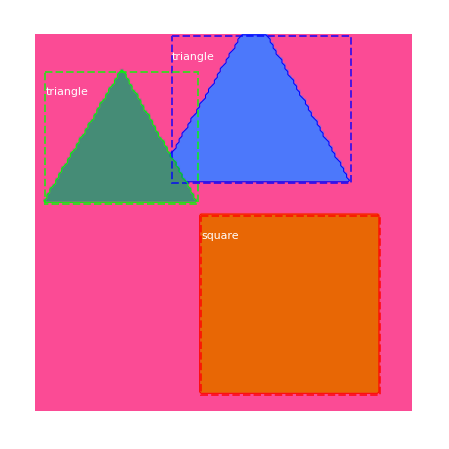

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   11.00000  max:  251.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -92.90000  max:  143.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


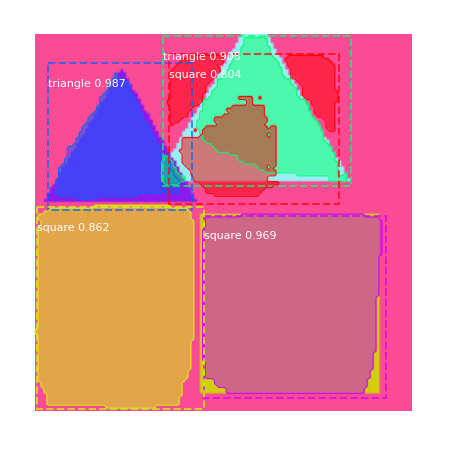

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
